In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from typing import List, Tuple, Optional, Dict
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import argparse
import json
import time
import os
from datetime import datetime

In [6]:
class EVL(nn.Module):
    """
    Pérdida EVT para **mínimos extremos**.

    Esta clase implementa un término de pérdida inspirado en Extreme Value Theory (EVT)
    para priorizar eventos raros de *mínimos* en series temporales. Se usa junto con
    una pérdida de regresión (MSE) y, opcionalmente, con un término de memoria.

    Parameters
    ----------
    gamma : float, default=1
        Exponente que controla el peso relativo de las partes (u/gamma)^gamma
        y (1 - u/gamma)^gamma. Debe ser > 0. Valores mayores endurecen el
        decaimiento, valores cercanos a 1 son más suaves.

    Atributos
    ---------
    gamma : float
        Copia del hiperparámetro usada internamente por la fórmula EVT.
    """

    def __init__(self, gamma: float = 1.0) -> None:
        super().__init__()
        self.gamma = gamma

    def evl_perdida_minimos(
        self,
        u: torch.Tensor,
        v: torch.Tensor,
        p_minimo: float
    ) -> torch.Tensor:
        """
        Calcula la pérdida EVT para **mínimos extremos** (forma estable numéricamente).

        Fórmula (por elemento)
        ----------------------
        L = - β_min * (u/γ)^γ * v * log(u)  -  β_norm * (1 - u/γ)^γ * (1 - v) * log(1 - u)

        donde `u` es probabilidad en (0,1), `v`∈{0,1} indica mínimo (1=min), `β_min = p_minimo`,
        `β_norm = 1 - p_minimo`, y `γ = gamma`.

        Parameters
        ----------
        u : torch.Tensor
            Probabilidades en (0, 1). Si llega fuera de rango/NaN/Inf, se estabiliza internamente.
            Shape: arbitraria y broadcastable con `v`.
        v : torch.Tensor
            Etiquetas binarias {0,1} donde 1 indica mínimo extremo. Si llegara en convención {-1,0},
            se mapea a {1,0} internamente. Shape: broadcastable con `u`.
        p_minimo : float
            Proporción esperada (0,1) de mínimos extremos (ajusta β). Si llega fuera de (0,1),
            se recorta a (eps, 1-eps).

        Returns
        -------
        torch.Tensor
            Tensor de pérdidas **por elemento** (no reducido). Reduce fuera con `.mean()` o `.sum()`.

        NOTAS IMPORTANTES
        -----------------
        - `torch.nan_to_num(u, ...)`: reemplaza NaN/±Inf por valores finitos (seguro para logs).
        - `u = u.clamp(eps, 1-eps)`: evita `log(0)` y `log(1-0)`, que producirían `-inf`.
        - `torch.log1p(-u)`: es `log(1-u)` pero más precisa y estable cerca de 0.
        - `base_min = clamp(u/gamma, eps, 1)`: asegura base positiva en `pow`; evita bases ≤0.
        - `torch.pow(base, gamma)`: si `gamma` no es entero, la base debe ser > 0 (de ahí el clamp).
        - El resultado **no** está reducido: decide tú si usar `.mean()` (típico) o `.sum()`.
        """
        eps = 1e-6

        # v a {0,1} (si viene como {-1,0}, se transforma a {1,0})
        v = v.float()
        if v.min() < 0 or v.max() > 1:
            v = (v == -1).float()

        # β en (0,1) y γ > 0 (recorte estable)
        beta_minimo = float(p_minimo)
        beta_minimo = max(min(beta_minimo, 1.0 - eps), eps)
        beta_normal = 1.0 - beta_minimo

        gamma = float(getattr(self, "gamma", 1.0))
        gamma = max(gamma, eps)

        # u estable en (0,1)
        u = torch.nan_to_num(u, nan=0.5, posinf=1.0, neginf=0.0)
        u = torch.clamp(u, eps, 1.0 - eps)

        # bases para potencias en (0,1] (evita negativos/cero)
        base_min = torch.clamp(u / gamma, eps, 1.0)         # (u/γ)^γ
        base_norm = torch.clamp(1.0 - (u / gamma), eps, 1.0) # (1 - u/γ)^γ

        # pesos
        pesos_minimos = beta_minimo * torch.pow(base_min, gamma)
        pesos_normal  = beta_normal  * torch.pow(base_norm, gamma)

        # términos log-estables
        log_u = torch.log(u)
        log_1mu = torch.log1p(-u)  # == log(1-u) con mejor estabilidad

        termino_minimo = -pesos_minimos * v        * log_u
        termino_normal = -pesos_normal  * (1.0 - v) * log_1mu

        loss_elem = termino_minimo + termino_normal
        loss_elem = torch.nan_to_num(loss_elem, nan=0.0, posinf=1e6, neginf=1e6)
        return loss_elem  # ← reducir fuera (p. ej., .mean())

    def forward(self, ut: torch.Tensor, vt: torch.Tensor, p_minimo: float) -> torch.Tensor:
        """
        Interfaz de compatibilidad: convierte `vt` a {0,1} y usa `-ut` como probabilidad de mínimo.

        Esto permite llamar a `EVL` como un módulo estándar (`loss = evl(ut, vt, p)`),
        asumiendo que `ut` es un *score* donde **más negativo ⇒ más extremo**.
        Se invierte el signo y se delega a `evl_perdida_minimos`.

        Parameters
        ----------
        ut : torch.Tensor
            Puntajes de extremidad (más negativo ⇒ más extremo). Shape broadcastable con `vt`.
        vt : torch.Tensor
            Etiquetas en {-1,0} o {0,1}. Si es {-1,0}, se mapea a {1,0}.
        p_minimo : float
            Proporción (0,1) de mínimos extremos.

        Returns
        -------
        torch.Tensor
            Pérdida por elemento (no reducida).

        NOTAS IMPORTANTES
        -----------------
        - Mapeo de etiquetas: `vt_minimo = (vt == -1).float()` produce {0,1}.
        - Inversión de signo: como `ut` más negativo es más extremo, `-ut` crece con la probabilidad
          de “ser mínimo”. Si `ut` ya es probabilidad en [0,1], preferir llamar directamente a
          `evl_perdida_minimos(ut, vt_minimo, p_minimo)` sin invertir.
        - Esta función **no reduce** la pérdida: reduce fuera con `.mean()` o `.sum()`.
        """
        vt_minimo = (vt == -1).float()
        return self.evl_perdida_minimos(-ut, vt_minimo, p_minimo)


In [7]:
class GRU_EVT(nn.Module):
    """
    GRU con memoria atencional y pérdida EVT para detección de mínimos extremos.

    El modelo predice el próximo valor de la serie y, simultáneamente, aprende
    a resaltar eventos raros de tipo **mínimo** usando:
      (1) una GRU como backbone,
      (2) un banco de memoria con embeddings de ventanas pasadas,
      (3) un score `ut` derivado de atención sobre la memoria,
      (4) una pérdida EVT (mínimos) además del MSE.

    Parameters
    ----------
    size_input : int
        Dimensión de entrada por paso temporal (número de features, F).
    size_oculto : int
        Dimensión del estado oculto de la GRU (H).
    size_memoria : int
        Capacidad del banco de memoria (M), número de embeddings almacenados.
    size_ventana : int
        Longitud de ventana W usada para codificar ventanas al banco de memoria.
    size_salida : int, default=1
        Dimensión de la salida por paso (normalmente 1 para series univariadas).
    gamma : float, default=1
        Hiperparámetro pasado a la pérdida EVT (exponente en la fórmula).
    labda : float, default=1
        Peso λ del término EVT de secuencia (L1) dentro de la pérdida total.
    lr : float, default=1e-4
        Tasa de aprendizaje prevista (el optimizador vive fuera de esta clase).

    Atributos
    ---------
    gru : nn.GRU
        GRU con `batch_first=True` ⇒ salidas `[B, T, H]` y oculto `[1, B, H]`.
    capa_salida : nn.Linear
        Proyección de `H → size_salida` para la predicción base (`pred_normal`).
    extreme_predictor : nn.Sequential
        MLP pequeño para estimar (logit/prob) de extremo a partir de embeddings `[H]`.
    b : nn.Parameter
        Parámetro escalar que modula la contribución de `ut` a la predicción final.
    embedding_modulo : Optional[torch.Tensor]
        Banco de memoria `S ∈ R^{M×H}` (embeddings de ventanas).
    historia_modulo : Optional[torch.Tensor]
        Etiquetas de memoria `Q ∈ {-1,0,1}^M` (se usa {−1,0} en este setup).
    evl_perdida : EVL
        Módulo con la pérdida EVT para mínimos extremos.
    umbral_ut : float
        Umbral fraccional para decidir extremos (UT ≤ −umbral). Puede calibrarse.
    lambda1 : float
        Peso de la pérdida EVT de secuencia.
    """

    def __init__(
        self,
        size_input: int,
        size_oculto: int,
        size_memoria: int,
        size_ventana: int,
        size_salida: int = 1,
        gamma: float = 1,
        labda: float = 1,
        lr: float = 0.0001,
    ) -> None:
        super(GRU_EVT, self).__init__()

        self.size_oculto = size_oculto
        self.size_memoria = size_memoria
        self.size_ventana = size_ventana
        self.gamma = gamma
        self.lambda1 = labda
        self.taza_aprendizaje = lr
        self.umbral_ut = 0.1

        # Backbone
        self.gru = nn.GRU(size_input, size_oculto, batch_first=True)

        # Salidas
        self.capa_salida = nn.Linear(size_oculto, size_salida)
        self.extreme_predictor = nn.Sequential(
            nn.Linear(size_oculto, size_oculto // 2),
            nn.ReLU(),
            nn.Linear(size_oculto // 2, 1),
            nn.Tanh()  # salida en (−1,1)
        )

        # Parámetro escalar (paper)
        self.b = nn.Parameter(torch.tensor(1.0, requires_grad=True))

        # Memoria
        self.embedding_modulo = None  # S ∈ R^{M×H}
        self.historia_modulo = None   # Q ∈ {-1,0,1}^M

        # EVT
        self.evl_perdida = EVL(gamma=gamma)

        # Stats (opcionales)
        self.p_derecha = 0
        self.p_izq = 0

    def inicializar_memoria(self, device: torch.device) -> None:
        """
        Inicializa los tensores del banco de memoria en el `device` indicado.

        Parameters
        ----------
        device : torch.device
            Dispositivo de destino (CPU o CUDA) para S y Q.

        NOTAS IMPORTANTES
        -----------------
        - `torch.zeros(..., device=device)`: crea el tensor directamente en el dispositivo.
        - Shapes:
            * `embedding_modulo` S: `[M, H]`
            * `historia_modulo`   Q: `[M]` con ints en {−1,0,1}
        """
        self.embedding_modulo = torch.zeros(self.size_memoria, self.size_oculto, device=device)
        self.historia_modulo = torch.zeros(self.size_memoria, dtype=torch.long, device=device)

    def actualizar_proporciones(self, vt_batch: torch.Tensor) -> None:
        """
        Actualiza la proporción de mínimos (`p_minimo`) a partir de un batch de etiquetas.

        Parameters
        ----------
        vt_batch : torch.Tensor
            Etiquetas por paso temporal, típicamente `{−1, 0}`. Shape: `[B, T]` o `[T]`.

        NOTAS IMPORTANTES
        -----------------
        - Se usa `vt_batch.cpu().numpy()` para computar proporciones con NumPy.
        - `p_minimo` se guarda como fracción en (0,1) y la consumen las pérdidas EVT.
        """
        vt_np = vt_batch.cpu().numpy()
        total = len(vt_np)
        self.p_minimo = np.sum(vt_np == -1) / total  # Solo mínimos

    def predecir_extremo_ventana(self, sj: torch.Tensor) -> torch.Tensor:
        """
        Estima (logit/prob) de extremo desde un embedding o lote de embeddings.

        Parameters
        ----------
        sj : torch.Tensor
            Embedding(s) de memoria. Shape `[M, H]` o `[H]`.

        Returns
        -------
        torch.Tensor
            Salida escalar por embedding (después de `squeeze`): `[M]` o `[]`.

        NOTAS IMPORTANTES
        -----------------
        - `Sequential` aplica capas a la **última dimensión** H.
        - `squeeze()` elimina dimensiones de tamaño 1 (la final aquí), dejando `[M]`.
        """
        return self.extreme_predictor(sj).squeeze()

    def computar_perdidas(
        self,
        prediccion: torch.Tensor,
        targets: torch.Tensor,
        ut_valores: torch.Tensor,
        vt_valores: torch.Tensor
    ) -> Dict[str, torch.Tensor]:
        """
        Compone la pérdida total: `MSE + lambda1 * EVT(secuencia) + EVT(memoria)`.

        Parameters
        ----------
        prediccion : torch.Tensor
            Predicción final apilada en el tiempo. Shape `[B, T, 1]`.
        targets : torch.Tensor
            Valores reales alineados con `prediccion`. Shape `[B, T, 1]`.
        ut_valores : torch.Tensor
            Score de extremidad por paso (más negativo ⇒ más extremo). Shape `[B, T]`.
        vt_valores : torch.Tensor
            Etiquetas por paso `{−1,0}`. Shape `[B, T]`.

        Returns
        -------
        dict
            Diccionario con `perdida_total`, `L1`, `L2`, `mse_perdida`, `evl_perdida_ut`.

        NOTAS IMPORTANTES
        -----------------
        - **Sanitización**: `torch.nan_to_num` evita NaN/Inf que romperían MSE o logs.
        - **u_prob**: si `ut` no está en [0,1], se mapea con `sigmoid(-ut/τ)` (más negativo → prob más alta).
        - **Clamp**: `clamp(eps, 1-eps)` previene `log(0)` en la pérdida EVT.
        - **Memoria (L2)**:
            * `predecir_extremo_ventana(S)` produce `[M]`; si es logit, se pasa por `sigmoid`.
            * `historia_modulo == -1` → target binario `[M]` en {0,1}.
            * Reduce con `.mean()` tras sanitizar.
        """
        import torch.nn.functional as F
        eps = 1e-6

        # Sanitizar entradas
        prediccion = torch.nan_to_num(prediccion, nan=0.0, posinf=1e6, neginf=-1e6)
        targets    = torch.nan_to_num(targets,    nan=0.0, posinf=1e6, neginf=-1e6)
        ut_valores = torch.nan_to_num(ut_valores, nan=0.0, posinf=1e6, neginf=-1e6)
        vt_valores = torch.nan_to_num(vt_valores, nan=0.0, posinf=1e6, neginf=-1e6)

        # MSE
        mse_loss = F.mse_loss(prediccion, targets)

        # EVT sobre secuencia (L1)
        v_bin = (vt_valores == -1).float()
        tau = 2  # suavizado de sigmoide
        u_prob = ut_valores
        if (u_prob.min() < 0) or (u_prob.max() > 1):
            u_prob = torch.sigmoid(-u_prob / tau)  # más negativo → prob(mínimo) ↑
        u_prob = u_prob.clamp(eps, 1 - eps)

        evl_loss_ut = self.evl_perdida.evl_perdida_minimos(u_prob, v_bin, self.p_minimo).mean()
        L1 = mse_loss + self.lambda1 * evl_loss_ut

        # EVT sobre memoria (L2)
        if (getattr(self, "embedding_modulo", None) is not None) and (getattr(self, "historia_modulo", None) is not None):
            pj_predicciones = self.predecir_extremo_ventana(self.embedding_modulo)  # [M]
            if (pj_predicciones.min() < 0) or (pj_predicciones.max() > 1):
                pj_predicciones = torch.sigmoid(pj_predicciones)
            pj_predicciones = pj_predicciones.clamp(eps, 1.0 - eps)

            qj_target = (self.historia_modulo == -1).float()  # [M]
            evl_L2 = self.evl_perdida.evl_perdida_minimos(pj_predicciones, qj_target, self.p_minimo)
            L2 = torch.nan_to_num(evl_L2, nan=0.0, posinf=1e6, neginf=-1e6).mean()
        else:
            L2 = prediccion.new_tensor(0.0)

        perdida_total = torch.nan_to_num(L1 + L2, nan=0.0, posinf=1e6, neginf=-1e6)

        return {
            'perdida_total': perdida_total,
            'L1': L1,
            'L2': L2,
            'mse_perdida': mse_loss,
            'evl_perdida_ut': evl_loss_ut
        }

    def forward(
        self,
        x: torch.Tensor,
        tiempo_actual: int,
        return_components: bool = False
    ) -> torch.Tensor | Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Computa la predicción en el paso `t` usando GRU + memoria atencional.

        Parameters
        ----------
        x : torch.Tensor
            Entrada acumulada hasta `t`. Shape `[B, t+1, F]` (por `batch_first=True`).
        tiempo_actual : int
            Índice temporal (0..T−1) correspondiente a `x[:, :t+1]`.
        return_components : bool, default=False
            Si True, devuelve `(pred_final, pred_normal, ut)`.

        Returns
        -------
        torch.Tensor | tuple
            Si False: `pred_final` `[B, 1]`.
            Si True : `(pred_final [B,1], pred_normal [B,1], ut [B])`.

        NOTAS IMPORTANTES
        -----------------
        - `gru(x)` → `gru_out [B, t+1, H]`, `oculto [1, B, H]` (último estado).
        - `oculto.squeeze(0)` → `[B, H]`: elimina el eje de capas (num_layers=1).
        - `pred_normal = capa_salida([B, H])` → `[B, 1]`: proyección lineal.
        - **Atención con memoria**:
            * Banco S `[M, H]`; similitud: `ultimo_oculto @ S.t()`:
              `[B, H] @ [H, M] = [B, M]`.
            * `softmax(dim=1)` normaliza por memoria (cada fila suma 1).
            * `historia_modulo` se pasa a **one-hot** `[M,3]` con índices `{−1,0,1}→{0,1,2}`.
            * Mezcla: `[B,M] @ [M,3] = [B,3]`; `ut = P(+1) − P(−1)` → `[B]`.
        - **Broadcasting**: `ut.unsqueeze(1)` → `[B,1]` para sumarlo a `pred_normal`.
        - `nan_to_num` protege contra NaN/Inf antes de salir.
        """
        batch_size, sucesion_len, _ = x.shape

        # GRU
        gru_out, oculto = self.gru(x)           # oculto: [1, B, H]
        ultimo_oculto = oculto.squeeze(0)       # [B, H]

        # Predicción base
        pred_normal = self.capa_salida(ultimo_oculto)  # [B, 1]

        # Atención de memoria → score ut
        ut = torch.zeros(batch_size, device=x.device)

        if (hasattr(self, 'embedding_modulo') and self.embedding_modulo is not None and
            hasattr(self, 'historia_modulo') and self.historia_modulo is not None):

            # Scores de atención: [B, H] @ [H, M] = [B, M]
            score_atencion = ultimo_oculto @ self.embedding_modulo.t()

            # Pesos de atención por memoria
            pesos_atencion = torch.softmax(score_atencion, dim=1)  # softmax por fila
            pesos_atencion = torch.nan_to_num(pesos_atencion, nan=0.0)

            # One-hot de historial Q (desplazado +1): [M,3]
            historia_one_hot = torch.zeros(self.size_memoria, 3, device=x.device)
            historia_one_hot[torch.arange(self.size_memoria), self.historia_modulo.long() + 1] = 1

            # Mezcla: [B,M] @ [M,3] = [B,3]
            contribucion_memoria = torch.matmul(pesos_atencion, historia_one_hot)  # [B,3]

            # ut = P(+1) − P(−1)  (índices 2 y 0 tras desplazar +1)
            ut = contribucion_memoria[:, 2] - contribucion_memoria[:, 0]          # [B]

        # Predicción final  (suma ponderada por 'b')
        pred_final = pred_normal + self.b * ut.unsqueeze(1)  # [B,1]
        ut = torch.nan_to_num(ut, nan=0.0, posinf=1e6, neginf=-1e6)

        if return_components:
            return pred_final, pred_normal, ut
        return pred_final

    def get_label(self, sucesion: torch.Tensor, time_step: int) -> int:
        """
        Heurística simple para etiquetar **mínimos** (−1) mirando el siguiente paso.

        Parameters
        ----------
        sucesion : torch.Tensor
            Secuencia parcial de la serie. Shape `[T]` o `[T, F]` (se toma la columna objetivo).
        time_step : int
            Índice actual (se usa hasta `time_step` para etiquetar `time_step+1`).

        Returns
        -------
        int
            `-1` si el siguiente paso cae por debajo del umbral (mínimo); `0` en caso contrario.

        NOTAS IMPORTANTES
        -----------------
        - Umbral: `valor_actual − 2 * std(sucesion[:t])`. Es una heurística (ajústala a tu dominio).
        - Si `time_step + 1` excede la longitud, devuelve `0` (no hay siguiente).
        """
        if time_step + 1 >= len(sucesion):
            return 0

        valor_actual = sucesion[time_step]
        valor_sig = sucesion[time_step + 1]

        umbral_abajo = valor_actual - 2 * torch.std(sucesion[:time_step])
        return -1 if valor_sig < umbral_abajo else 0

    def sample_historia(
        self,
        tiempo_actual: int,
        sucesion: torch.Tensor,
        vt_sucesion: torch.Tensor
    ) -> Tuple[List[torch.Tensor], List[int]]:
        """
        Muestrea ventanas para el banco de memoria priorizando pasos extremos.

        Parameters
        ----------
        tiempo_actual : int
            Paso temporal actual; se consideran finales de ventana `< tiempo_actual`.
        sucesion : torch.Tensor
            Secuencia de **una** muestra (usualmente `[T, F]`).
        vt_sucesion : torch.Tensor
            Etiquetas `[T]` con {−1,0}.

        Returns
        -------
        ventanas : list of torch.Tensor
            Lista de ventanas `[1, W, F]` (se añade `unsqueeze(0)` como eje batch).
        labels : list of int
            Etiquetas por ventana en {−1,0} para la posición `final`.

        NOTAS IMPORTANTES
        -----------------
        - **Device**: se fuerzan todos los índices/tensores a estar en el **mismo device**.
        - Índices válidos: `range(W, t−1)`. Cada índice es el **final** de una ventana `[i−W:i]`.
        - Priorización: se toman **todos** los extremos disponibles y se completa con normales hasta `k`.
        - `unsqueeze(0)`: ventana `[W,F]` → `[1,W,F]`, listo para pasar por la GRU.
        """
        ventanas, labels = [], []

        if tiempo_actual <= self.size_ventana + 1:
            return [], []

        device = vt_sucesion.device
        if sucesion.device != device:
            sucesion = sucesion.to(device)

        indices = torch.arange(self.size_ventana, tiempo_actual - 1, device=device)
        if indices.numel() == 0:
            return [], []

        vt_seg = vt_sucesion[self.size_ventana:tiempo_actual - 1].to(device)
        ext_mask = (vt_seg == -1)
        if ext_mask.device != indices.device:
            ext_mask = ext_mask.to(indices.device)

        ext_indices  = indices[ext_mask]
        norm_indices = indices[~ext_mask]

        k = min(getattr(self, "size_memoria", self.size_ventana), indices.numel())

        sel_ext = ext_indices
        faltan = k - sel_ext.numel()
        if faltan > 0:
            if norm_indices.numel() >= faltan:
                perm = torch.randperm(norm_indices.numel(), device=device)[:faltan]
                sel_norm = norm_indices[perm]
            else:
                if norm_indices.numel() > 0:
                    rnd = torch.randint(0, norm_indices.numel(), (faltan,), device=device)
                    sel_norm = norm_indices[rnd]
                else:
                    sel_norm = torch.empty(0, dtype=indices.dtype, device=device)
            sample_id = torch.cat([sel_ext, sel_norm], dim=0)
        else:
            perm = torch.randperm(sel_ext.numel(), device=device)[:k]
            sample_id = sel_ext[perm]

        for idx in sample_id.tolist():
            inicio, final = idx - self.size_ventana, idx
            ventana = sucesion[inicio:final]          # [W, F]
            etiqueta = int(vt_sucesion[final].item()) # etiqueta para ese final
            etiqueta = -1 if etiqueta == -1 else 0
            ventanas.append(ventana.unsqueeze(0))     # [1, W, F]
            labels.append(etiqueta)

        return ventanas, labels

    def actualizar_memoria(self, ventanas: List[torch.Tensor], labels: List[int]) -> None:
        """
        Actualiza el banco de memoria con nuevos embeddings y sus etiquetas.

        Parameters
        ----------
        ventanas : list of torch.Tensor
            Ventanas `[1, W, F]` listas para codificar con la GRU.
        labels : list of int
            Etiquetas por ventana {−1,0}.

        NOTAS IMPORTANTES
        -----------------
        - Codificación: `gru(ventana)` devuelve `oculto [1,1,H]`. Con `squeeze(0).squeeze(0)` queda `[H]`.
        - Apilado: `stack([...], dim=0)` produce `[M, H]` listo para concatenar al banco.
        - Desplazamiento circular: `cat([S[new:], new_embeddings], dim=0)` mantiene tamaño `M`.
        - Las etiquetas se concatenan en `historia_modulo` de forma paralela.
        """
        if len(ventanas) == 0:
            return

        with torch.no_grad():
            embeddings = []
            for ventana in ventanas:
                _, oculto = self.gru(ventana)          # oculto: [1,1,H]
                emb = oculto.squeeze(0).squeeze(0)     # [H]
                embeddings.append(emb)
            embeddings = torch.stack(embeddings, dim=0)  # [M, H]

        size_memoria_nueva = embeddings.size(0)

        if self.embedding_modulo is None:
            self.inicializar_memoria(embeddings.device)

        # Desplaza y concatena (mantiene tamaño M)
        self.embedding_modulo = torch.cat([
            self.embedding_modulo[size_memoria_nueva:],  # “antiguas” que sobreviven
            embeddings                                   # nuevas al final
        ], dim=0)

        labels_tensor = torch.tensor(labels, dtype=torch.long, device=self.historia_modulo.device)
        self.historia_modulo = torch.cat([
            self.historia_modulo[size_memoria_nueva:],
            labels_tensor
        ], dim=0)


In [8]:
class EntrenamientoEVT(nn.Module):
    """
    Orquestador de entrenamiento/validación para `GRU_EVT` con pérdida EVT.

    Esta clase envuelve al modelo `GRU_EVT` y maneja:
    - el loop de entrenamiento por épocas,
    - la evaluación en validación,
    - la calibración del umbral de UT para clasificación de extremos,
    - el registro de pérdidas (train/val) y early stopping.

    Parameters
    ----------
    size_input : int
        Número de features por paso temporal (F) que entran a la GRU.
    size_oculto : int
        Tamaño del estado oculto de la GRU (H).
    size_memoria : int
        Capacidad del banco de memoria (M) usado por el modelo.
    size_ventana : int
        Longitud de ventana W para construir embeddings de memoria.
    tasa_aprendizaje : float, default=0.001
        Learning rate para el optimizador Adam.
    gamma : float, default=1
        Hiperparámetro que se pasa a la pérdida EVT (exponente).
    labda1 : float, default=1
        Peso λ de la pérdida EVT de secuencia (L1) dentro de la pérdida total.

    Atributos
    ---------
    device : torch.device
        `cuda` si está disponible, de lo contrario `cpu`.
    model : GRU_EVT
        Modelo principal (GRU+Memoria+EVT).
    optimizador : torch.optim.Optimizer
        Optimizador Adam sobre los parámetros del modelo.
    lambda1 : float
        Peso del término EVT en la pérdida L1.
    loss_history : dict
        Registro de pérdidas con claves `train` y `val`.
    last_val_f1 : float
        Último F1 de extremos medido en validación (para logging).
    """

    def __init__(self, size_input, size_oculto, size_memoria, size_ventana,
                 tasa_aprendizaje=0.001, gamma=1, labda1=1):
        super(EntrenamientoEVT, self).__init__()
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = GRU_EVT(
            size_input=size_input,
            size_oculto=size_oculto,
            size_memoria=size_memoria,
            size_ventana=size_ventana,
            gamma=gamma,
            labda=labda1,
            lr = tasa_aprendizaje
        ).to(self.device)

        try:
            self.model.gru.flatten_parameters()
        except:
            pass
        
        self.optimizador = optim.Adam(self.model.parameters(), lr=tasa_aprendizaje)
        self.lambda1 = labda1
        self.loss_history = {'train': [], 'val': []}
    
    def alinear_targets(self, predicciones, targets, vt_labels):
        """
        Alinea `targets` y `vt_labels` con la longitud temporal de `predicciones`.

        Caso típico *next-step*: si `targets` tiene T_pred+1 pasos, se recorta
        como `targets[:, 1:1+T_pred]` para que la predicción de `t` compare con el real `t+1`.

        Parameters
        ----------
        predicciones : torch.Tensor
            Tensor apilado de predicciones por paso. Shape `[B, T_pred, 1]`.
        targets : torch.Tensor
            Valores reales. Shape `[B, T_tgt]` o `[B, T_tgt, 1]`.
        vt_labels : torch.Tensor
            Etiquetas por paso `{−1, 0}` con shape `[B, T_tgt]`.

        Returns
        -------
        targets : torch.Tensor
            Targets **alineados** a `T_pred`. Shape `[B, T_pred, 1]`.
        vt_slice : torch.Tensor
            Etiquetas alineadas a `T_pred`. Shape `[B, T_pred]`.

        NOTAS IMPORTANTES
        -----------------
        - Si `targets.dim()==2`, se hace `unsqueeze(-1)` → `[B,T,1]` para matchear `[B,T,1]`.
        - Si `T_tgt == T_pred + 1`, recorte `[1:1+T_pred]` (desplazamiento +1).
        - Si no, se truncan ambos a `:T_pred`.
        """
        if targets.dim() == 2:
            targets = targets.unsqueeze(-1)
        T_pred = predicciones.size(1)
        if targets.size(1) == T_pred + 1:
            targets = targets[:, 1:1+T_pred, :]
            vt_slice = vt_labels[:, 1:1+T_pred]
        else:
            targets = targets[:, :T_pred, :]
            vt_slice = vt_labels[:, :T_pred]
        return targets, vt_slice


    def entrenar_epoca(self, train_loader):
        """
        Ejecuta **una época** de entrenamiento completa sobre `train_loader`.

        Recorre cada batch, resetea memoria por batch, acumula predicciones paso a paso,
        alinea targets y calcula la pérdida total (MSE + EVT secuencia + EVT memoria).

        Parameters
        ----------
        train_loader : torch.utils.data.DataLoader
            Loader que entrega tuplas `(data, targets, vt_labels)`.

        Returns
        -------
        float
            Pérdida media de entrenamiento en la época.

        NOTAS IMPORTANTES
        -----------------
        - `self.model.inicializar_memoria(self.device)`: memoria limpia **por batch**.
        - Bucle temporal: para cada `t`, entrada acumulada `data[:, :t+1, :]` (shape `[B,t+1,F]`).
        - `pred_todas` acumula tensores `[B,1]` y luego `stack(..., dim=1)` → `[B,T_pred,1]`.
        - `ut_val_todos` acumula `[B]` y `stack(..., dim=1)` → `[B,T_pred]`.
        - Clipping: `clip_grad_norm_` estabiliza entrenamiento en secuencias largas.
        - `nan_to_num` en gradientes y pesos protege contra NaN/Inf tras el step.
        """

        try:
            self.model.gru.flatten_parameters()
        except Exception:
            pass
        self.model.train()
        total_loss = 0.0
        for batch_idx, (data, targets, vt_labels) in enumerate(train_loader):
            data, targets, vt_labels = data.to(self.device), targets.to(self.device), vt_labels.to(self.device)

            # Reiniciar memoria para cada batch
            self.model.inicializar_memoria(self.device)

            self.optimizador.zero_grad()
            self.model.actualizar_proporciones(vt_labels)

            batch_size, sec_len, _ = data.shape
            pred_todas, ut_val_todos = [], []

            for t in range(sec_len):
                input_actual = data[:, :t+1, :]
                if t > self.model.size_ventana:
                    ventanas, labels = self.model.sample_historia(t, data[0, :t], vt_labels[0])
                    self.model.actualizar_memoria(ventanas, labels)

                pred, normal_pred, ut = self.model(input_actual, t, return_components=True)
                pred_todas.append(pred)
                ut_val_todos.append(ut)

            predicciones = torch.stack(pred_todas, dim=1)  # [B, T_pred, 1]
            ut_valores   = torch.stack(ut_val_todos, dim=1) # [B, T_pred]

            targets, vt_slice = self.alinear_targets(predicciones, targets, vt_labels)
            perdidas = self.model.computar_perdidas(predicciones, targets, ut_valores, vt_slice)

            perdidas['perdida_total'].backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            # Sanitiza gradientes (por si algún op devuelve inf/NaN)
            for p in self.model.parameters():
                if p.grad is not None:
                    p.grad.data = torch.nan_to_num(p.grad.data, nan=0.0, posinf=1e6, neginf=-1e6)

            self.optimizador.step()

            # Sanitiza pesos tras el step
            with torch.no_grad():
                for p in self.model.parameters():
                    p.data = torch.nan_to_num(p.data, nan=0.0, posinf=1e6, neginf=-1e6)

            total_loss += float(perdidas['perdida_total'].detach().cpu())

            # (Opcional) debug cada N batches
            if getattr(self, "debug", False) and (batch_idx % 100 == 0):
                print(
                    f"evl_ut={float(perdidas['evl_perdida_ut']):.4e} "
                    f"L1={float(perdidas['L1']):.4e} L2={float(perdidas['L2']):.4e} "
                    f"total={float(perdidas['perdida_total']):.4e}")

        return total_loss / max(1, len(train_loader))


    def evaluar(self, val_loader):
        """
        Evalúa en validación, regresando la pérdida media y guardando F1 de extremos.

        Parameters
        ----------
        val_loader : torch.utils.data.DataLoader
            Loader de validación que puede devolver (data, targets, vt) o (data, targets, ut, vt).

        Returns
        -------
        float
            Pérdida media en validación.

        NOTAS IMPORTANTES
        -----------------
        - Si el batch trae 4 elementos, se ignora `ut_labels` y se usa `vt_labels`.
        - Bucle temporal usa `range(sec_len - 1)` para evitar desbordes al alinear.
        - `stack` y `alinear_targets` se usan igual que en entrenamiento.
        - Métrica de extremos:
            * Predicción binaria: `ut ≤ −umbral`.
            * Verdad: `vt == −1`.
            * F1 se calcula con `sklearn.metrics.f1_score`.
        """

        try:
            self.model.gru.flatten_parameters()
        except Exception:
            pass
        self.model.eval()
        total_loss = 0.0
        total_batches = 0
        self.last_val_f1 = float('nan')  # por si no se calcula

        with torch.no_grad():
            for batch in val_loader:
                if isinstance(batch, (list, tuple)) and len(batch) == 4:
                    data, targets, ut_labels, vt_labels = batch
                elif isinstance(batch, (list, tuple)) and len(batch) == 3:
                    data, targets, vt_labels = batch  # val/test devuelven vt
                    ut_labels = vt_labels            # placeholder no usado
                else:
                    raise ValueError(f"Esperaba 3 o 4 elementos por batch, recibí {len(batch)}.")

                data, targets = data.to(self.device), targets.to(self.device)
                ut_labels, vt_labels = ut_labels.to(self.device), vt_labels.to(self.device)

                sec_len = data.size(1)
                pred_todas, ut_val_todos = [], []

                for t in range(sec_len - 1):
                    input_actual = data[:, :t+1, :]
                    if t > self.model.size_ventana:
                        ventanas, labels = self.model.sample_historia(t, data[0, :t], vt_labels[0])
                        self.model.actualizar_memoria(ventanas, labels)

                    pred, normal_pred, ut = self.model(input_actual, t, return_components=True)
                    pred_todas.append(pred)
                    ut_val_todos.append(ut)

                predicciones = torch.stack(pred_todas, dim=1)
                ut_valores   = torch.stack(ut_val_todos, dim=1)

                targets, vt_slice = self.alinear_targets(predicciones, targets, vt_labels)
                perdidas = self.model.computar_perdidas(predicciones, targets, ut_valores, vt_slice)

                total_loss += float(perdidas['perdida_total'].detach().cpu())
                total_batches += 1

                # F1 de extremos en validación
                umbral = float(getattr(self.model, "umbral_ut", getattr(self.model, "p_minimo", 0.1)))
                if umbral > 1:
                    umbral = umbral / 100.0
                pred_extremo_val = (ut_valores <= -umbral)
                true_extremo_val = (vt_slice == -1)
                from sklearn.metrics import f1_score
                y_pred_val = pred_extremo_val.detach().cpu().numpy().astype(int).ravel()
                y_true_val = true_extremo_val.detach().cpu().numpy().astype(int).ravel()
                self.last_val_f1 = f1_score(y_true_val, y_pred_val, zero_division=0)

        return total_loss / max(1, total_batches)

    def calibrar_umbral_ut(self, val_loader):
        """
        Busca el umbral `t` que maximiza **F1** de extremos en validación (grid simple).

        Recorre una rejilla t ∈ [0.02, 0.6] y elige el que mejor F1 produce para la
        regla `pred = (ut ≤ −t)` vs `true = (vt == −1)`.

        Parameters
        ----------
        val_loader : torch.utils.data.DataLoader
            Loader de validación.

        Returns
        -------
        (best_t, best_f1) : tuple[float, float]
            Umbral elegido y el F1 correspondiente.

        NOTAS IMPORTANTES
        -----------------
        - Se acumulan secuencias de UT por batch, se alinean VT y se aplanan.
        - Si `ut` no está en [0,1], no importa: aquí se usa como **score ordenable** (más negativo ⇒ más extremo).
        - Requiere `from sklearn.metrics import f1_score` (asegúrate de importar dentro o fuera).
        """
        self.model.eval()
        uts, vts = [], []
        with torch.no_grad():
            for batch in val_loader:
                if isinstance(batch, (list, tuple)) and len(batch) == 4:
                    data, targets, ut_labels, vt_labels = batch
                else:
                    data, targets, vt_labels = batch
                data, vt_labels = data.to(self.device), vt_labels.to(self.device)

                sec_len = data.size(1)
                ut_steps = []
                for t in range(sec_len - 1):
                    inp = data[:, :t+1, :]
                    _, _, ut = self.model(inp, t, return_components=True)
                    ut_steps.append(ut)
                ut_seq = torch.stack(ut_steps, dim=1)  # [B, T]
                # Reusa tu helper de alineación para recortar vt
                _, vt_slice = self.alinear_targets(ut_seq.unsqueeze(-1), targets, vt_labels)
                uts.append(ut_seq.detach().cpu().numpy().ravel())
                vts.append((vt_slice == -1).float().cpu().numpy().ravel())

        ut_all = np.concatenate(uts)   # en [-1, 0]
        vt_all = np.concatenate(vts).astype(int)

        best_t, best_f1 = 0.10, -1.0
        for t in np.linspace(0.02, 0.6, 60):
            pred = (ut_all <= -t).astype(int)
            from sklearn.metrics import f1_score  # <- asegúrate de tenerlo importado
            f1 = f1_score(vt_all, pred, zero_division=0)
            if f1 > best_f1:
                best_f1, best_t = f1, t

        self.model.umbral_ut = float(best_t)
        return best_t, best_f1

    def entrenar_epocas(self, train_loader, val_loader, epochs=100, paciencia=10):
        """
        Entrena múltiples épocas con early stopping según pérdida de validación.

        Parameters
        ----------
        train_loader : torch.utils.data.DataLoader
            Loader de entrenamiento.
        val_loader : torch.utils.data.DataLoader
            Loader de validación.
        epochs : int, default=100
            Número máximo de épocas.
        paciencia : int, default=10
            Paciencia para early stopping (número de épocas sin mejora).

        Returns
        -------
        dict
            Diccionario `{'train': [...], 'val': [...]}` con el historial de pérdidas.

        NOTAS IMPORTANTES
        -----------------
        - Early stopping guarda el **mejor estado** con `torch.save(state_dict)`.
        - Logging incluye F1 de extremos (`self.last_val_f1`) actualizado en `evaluar`.
        - Al finalizar, se carga el mejor checkpoint y (opcionalmente) se calibra el umbral UT.
        """
        mejor_perdida_val = float('inf')
        contador_paciencia = 0
        
        for epoch in range(epochs):
            # Entrenamiento
            train_loss = self.entrenar_epoca(train_loader)
            self.loss_history['train'].append(train_loss)
            
            # Validación
            val_loss = self.evaluar(val_loader)
            self.loss_history['val'].append(val_loss)
            
            # Early stopping
            if val_loss < mejor_perdida_val:
                mejor_perdida_val = val_loss
                contador_paciencia = 0
                # Guardar mejor modelo
                torch.save(self.model.state_dict(), 'mejor_modelo.pth')
            else:
                contador_paciencia += 1
                if contador_paciencia >= paciencia:
                    print(f"Early stopping en época {epoch}")
                    break
            
            # Logging
            f1_txt = f" | Val F1(ext): {getattr(self, 'last_val_f1', float('nan')):.3f}"
            print(f"Época {epoch:3d} | Train Loss: {train_loss:.6e} | Val Loss: {val_loss:.6e}{f1_txt} | Paciencia: {contador_paciencia}/{paciencia}")

        
        # Cargar mejor modelo
        state = torch.load('mejor_modelo.pth', map_location=self.device)
        self.model.load_state_dict(state)

        # Calibrar umbral con validación (opcional pero recomendado)
        try:
            umbral, f1 = self.calibrar_umbral_ut(val_loader)
        except Exception as e:
            # TODO: maneja la excepción si decides silenciarla (p. ej., print(e) o pass)
            # Dejar vacío produce SyntaxError en Python.
            ...
        
        return self.loss_history


In [9]:
class Data:
    """
    Utilidades de preparación de datos para series temporales con detección de mínimos.

    Esta clase:
      1) Carga el CSV, separa `X` (todas las columnas ≠ `target`) y `y` (`target`),
      2) Estandariza `X` e `y` con `StandardScaler`,
      3) Genera **sucesiones** (ventanas deslizantes) para *next-step prediction*,
      4) Etiqueta **mínimos extremos** por ventana,
      5) Realiza la partición train/val/test (sin mezclar orden temporal).

    Parameters
    ----------
    ruta : str
        Ruta al CSV. Se espera que el índice de la primera columna pueda usarse como índice temporal (opcional).
    target : str
        Nombre de la columna objetivo (serie a predecir).
    suc_long : int
        Longitud de cada **sucesión** (ventana) `W`.

    Atributos
    ---------
    scaler_x : StandardScaler
        Escalador para las features `X`.
    scaler_y : StandardScaler
        Escalador para el objetivo `y`.
    feature : list[str] | None
        Lista de nombres de columnas usadas como features (todas salvo `target`).
    verbose : bool
        Si `True`, imprime conteos de mínimos detectados por ventana.
    """

    def __init__(self, ruta, target, suc_long):
        self.ruta = ruta
        self.target = target
        self.suc_long = suc_long
        self.scaler_x = StandardScaler()
        self.scaler_y = StandardScaler()
        self.feature = None
        self.verbose = False

    def cargar_datos(self):
        """
        Carga el CSV, separa `X` y `y`, y aplica estandarización (z-score).

        Returns
        -------
        X_scaled : np.ndarray
            Matriz de features escaladas. Shape `[N, F]` (float32).
        y_scaled : np.ndarray
            Objetivo escalado. Shape `[N, 1]` (float32).
        df : pd.DataFrame
            DataFrame original cargado (sin modificar los tipos ni el orden de columnas).

        NOTAS IMPORTANTES
        -----------------
        - `feature = [col for col in df.columns if col != target]`
          Usa **todas** las columnas ≠ `target` como entrada.
        - `y.reshape(-1,1)` garantiza shape `[N, 1]` (no `[N]`) para escalado/ventanas.
        - **Fuga de información**: aquí `StandardScaler.fit_transform` se aplica sobre **todo** el dataset
          (train+val+test). Si deseas evitar fuga, ajusta los scalers **solo con training** y después
          aplica `.transform` en val/test.
        - Dtypes: se castea a `np.float32` por compatibilidad con PyTorch y eficiencia.
        """
        df = pd.read_csv(self.ruta, index_col=0)

        self.feature = [col for col in df.columns if col != self.target]
        X = df[self.feature].values.astype(np.float32)         # [N, F]
        y = df[self.target].values.astype(np.float32).reshape(-1, 1)  # [N, 1]

        X_scaled = self.scaler_x.fit_transform(X)  # [N, F]
        y_scaled = self.scaler_y.fit_transform(y)  # [N, 1]

        return X_scaled, y_scaled, df
    
    def detectar_extremos(self, y_sucesion, metodo) -> np.ndarray:
        """
        Etiqueta mínimos extremos dentro de **una sucesión** (ventana) de `y`.

        Parameters
        ----------
        y_sucesion : np.ndarray
            Ventana del objetivo escalado. Shape `[W, 1]` o `[W]`.
        metodo : {"percentil", "zscore-like"}
            - `"percentil"`: marca −1 por debajo del **percentil 15** de la ventana.
            - otro (fallback): marca −1 por debajo de `media − 1.5 * std` de la ventana.

        Returns
        -------
        vt : np.ndarray
            Vector de etiquetas de longitud `W` con valores en {0, −1}.
            Donde −1 indica **mínimo extremo** y 0 indica normal.

        NOTAS IMPORTANTES
        -----------------
        - `y_sucesion.flatten()` → `[W]` para trabajar con percentiles/std fácilmente.
        - La etiqueta se asigna **comparando cada punto de la ventana** contra el umbral
          de esa **misma** ventana (método adaptativo por ventana).
        - Si `verbose=True`, se imprime el conteo de mínimos detectados por ventana.
        - Los umbrales (p15 o μ−1.5σ) son **heurísticos**; ajusta a tu dominio si necesitas
          mayor/menor sensibilidad.
        """
        y_flat = y_sucesion.flatten()
        vt = np.zeros(len(y_flat))

        if metodo == 'percentil':
            lower_threshold = np.percentile(y_flat, 15) 
            vt[y_flat < lower_threshold] = -1
        else:
            mean_val = np.mean(y_flat)
            std_val = np.std(y_flat)
            lower_threshold = mean_val - 1.5 * std_val
            vt[y_flat < lower_threshold] = -1 

        if self.verbose:
            n_ext = int(np.sum(vt == -1))
            print(f"Mínimos extremos detectados: {n_ext}/{len(vt)} ({(n_ext/len(vt))*100:.1f}%)")
        return vt

    def crear_sucesiones(self, X, y, metodo):
        """
        Construye ventanas deslizantes de longitud `W = suc_long` para X, y y vt.

        Para *next-step prediction*: la sucesión de `y` se toma **desplazada +1**,
        es decir, para X[i : i+W] el objetivo es y[i+1 : i+W+1].

        Parameters
        ----------
        X : np.ndarray
            Features escaladas. Shape `[N, F]`.
        y : np.ndarray
            Objetivo escalado. Shape `[N, 1]`.
        metodo : {"percentil", "zscore-like"}
            Método para etiquetar mínimos en cada sucesión (ver `detectar_extremos`).

        Returns
        -------
        X_sucesion : np.ndarray
            Tensor de sucesiones de features. Shape `[N−W, W, F]`.
        y_sucesion : np.ndarray
            Tensor de sucesiones objetivo **desplazadas +1**. Shape `[N−W, W, 1]`.
        vt_sucesion : np.ndarray
            Etiquetas por sucesión (cada una de longitud W) en {0, −1}. Shape `[N−W, W]`.

        NOTAS IMPORTANTES
        -----------------
        - `n = N − W` es el número de sucesiones completas que se pueden extraer.
        - Para cada `i`:
            * `X_suc = X[i : i+W]` → shape `[W, F]`.
            * `y_suc = y[i+1 : i+W+1]` → shape `[W, 1]` (**desplazado +1**).
            * `vt_suc = detectar_extremos(y_suc, metodo)` → `[W]`.
        - El **desplazamiento +1** alinea el *target* del paso `t` con la **predicción del paso previo**
          (lo que tu modelo aprende en cada `t` es a predecir el `t+1`).
        """
        n = len(X) - self.suc_long
        X_sucesion, y_sucesion, vt_sucesion = [], [], []

        for i in range(n):
            X_suc = X[i:i+self.suc_long]                 # [W, F]
            y_suc = y[i+1:i+self.suc_long+1]            # [W, 1]  (shift +1)
            vt_suc = self.detectar_extremos(y_suc, metodo=metodo)  # [W]
            X_sucesion.append(X_suc)
            y_sucesion.append(y_suc)
            vt_sucesion.append(vt_suc)
        
        return np.array(X_sucesion), np.array(y_sucesion), np.array(vt_sucesion)
    
    def procesar_datos(self, metodo, test_size=0.3, val_size=0.15):
        """
        Pipeline completo: carga/escala, crea sucesiones y separa train/val/test.

        Parameters
        ----------
        metodo : {"percentil", "zscore-like"}
            Método para detección de mínimos por sucesión.
        test_size : float, default=0.2
            Proporción para test (en fracción de sucesiones).
        val_size : float, default=0.1
            Proporción para validación **dentro del split de entrenamiento**.
            Es decir, primero se separa test (`test_size`) y luego se divide
            el restante en train/val con esta proporción.

        Returns
        -------
        (X_train, y_train, vt_train) : tuple[np.ndarray, np.ndarray, np.ndarray]
            Sucesiones de entrenamiento.
        (X_val, y_val, vt_val) : tuple[np.ndarray, np.ndarray, np.ndarray]
            Sucesiones de validación.
        (X_test, y_test, vt_test) : tuple[np.ndarray, np.ndarray, np.ndarray]
            Sucesiones de prueba.

        NOTAS IMPORTANTES
        -----------------
        - `train_test_split(..., shuffle=False)`: mantiene el **orden temporal** (muy importante en series).
        - El split `val_size` se aplica **sobre el remanente** después de extraer test.
        - Shapes:
            * `X_*` → `[N_*, W, F]`
            * `y_*` → `[N_*, W, 1]`
            * `vt_*` → `[N_*, W]` con valores {0, −1}
        - Si deseas evitar **fuga de información** en el escalado:
            1) llama a `cargar_datos` solo para leer `df`,
            2) ajusta `scaler_x`/`scaler_y` **con train**,
            3) transforma val/test con `.transform`.
          Aquí se usa la ruta simple (fit sobre todo el dataset) para reproducibilidad rápida.
        """
        X, y, df = self.cargar_datos()
        X_suc, y_suc, vt_suc = self.crear_sucesiones(X, y, metodo)

        X_train, X_test, y_train, y_test, vt_train, vt_test = train_test_split(
            X_suc, y_suc, vt_suc, test_size=test_size, random_state=42, shuffle=False
        )
    
        X_train, X_val, y_train, y_val, vt_train, vt_val = train_test_split(
            X_train, y_train, vt_train, test_size=val_size, random_state=42, shuffle=False
        )

        return (X_train, y_train, vt_train), (X_val, y_val, vt_val), (X_test, y_test, vt_test)


In [10]:
def load_config() -> dict:
    """
    Carga la configuración del experimento combinando valores por defecto y, si existe,
    un archivo `config.json` en el directorio de trabajo que puede **sobrescribir** los
    defaults.

    Returns
    -------
    dict
        Diccionario de configuración final con (al menos) las siguientes claves:

        - excel_path : str
            Ruta al CSV/Excel con los datos. Úsalo en `Data(ruta=...)`.
        - target_column : str
            Nombre de la columna objetivo (y).
        - input_size : int
            Número de features (F) que entran a la GRU. Debe coincidir con las columnas
            **no-target** que pasas a `Data`.
        - hidden_size : int
            Tamaño del estado oculto de la GRU (H).
        - memory_size : int
            Capacidad del banco de memoria (M) en `GRU_EVT`.
        - window_size : int
            Longitud de ventana (W) para construir embeddings de memoria.
        - seq_length : int
            Longitud de la secuencia que alimenta a la GRU por muestra (T).
        - batch_size : int
            Tamaño de lote (B) en los `DataLoader`.
        - learning_rate : float
            Tasa de aprendizaje para Adam.
        - gamma : float
            Parámetro de la pérdida EVT (exponente en la fórmula).
        - lambda1 : float
            Peso λ del término EVT de secuencia dentro de la pérdida total.

    Notas
    -----
    - **Precedencia**: primero se definen los *defaults*; si existe `config.json`,
      se leen sus claves y se hace `default_config.update(loaded_config)` para
      **sobrescribir** valores.
    - **Rutas**: en Windows puedes usar `r'C:\\path\\al\\archivo.csv'` o
      `'C:/path/al/archivo.csv'`. Si pones la ruta en `config.json`, prefiere
      el formato con **slashes** (`/`) para portabilidad.
    - **Coherencia de shapes**:
        * `input_size == número de columnas de X` (todas las no-target).
        * `hidden_size == H` debe ser consistente con capas lineales que proyectan H→1.
        * `window_size == W` afecta a `sample_historia` y a la construcción de memoria.
        * `seq_length == T` es la longitud temporal que verán los bucles `for t in range(T)`.
    - **Validación**: si vas a permitir claves extra en `config.json`, documenta qué se ignora
      y qué se utiliza; si quieres ser estricto, valida contra un conjunto permitido.
    - **Ejemplo mínimo de `config.json`**:
      {
        "excel_path": "data/Base.csv",
        "target_column": "caudal_minimo",
        "input_size": 68,
        "hidden_size": 64,
        "memory_size": 30,
        "window_size": 10,
        "seq_length": 30,
        "batch_size": 8,
        "learning_rate": 1e-4,
        "gamma": 1,
        "lambda1": 2
      }

    NOTAS IMPORTANTES
    -----------------
    - `os.path.exists('config.json')`:
      si el archivo existe, **sobrescribe** (update) los defaults con sus valores.
    - `json.load(f)`:
      convierte el JSON en dict; si hay tipos erróneos (p. ej., strings donde esperas int),
      conviene validar antes de usar.
    - Si cambias `input_size` (p. ej., al filtrar columnas), recuerda actualizarlo aquí
      o en tu código antes de instanciar el modelo.
    """
    default_config = {
        "excel_path": r'C:\Users\andre\OneDrive\Documentos\II2025\Asistencia CIMPA\Cuencas\ValoresExtremos\data\Brujo\BaseCompletaFecha.csv',
        "target_column": "caudal_minimo",
        "input_size": 68,
        "hidden_size": 64,
        "memory_size": 30,
        "window_size": 10,
        "seq_length": 30,
        "batch_size": 8,
        "learning_rate": 1e-4,
        "gamma": 1,
        "lambda1": 2
    }

    if os.path.exists('config.json'):
        with open('config.json', 'r', encoding='utf-8') as f:
            loaded_config = json.load(f)
            # Sobrescribe defaults con lo que venga en el JSON:
            default_config.update(loaded_config)

    return default_config


In [11]:
def inicializar():
    """
    Construye la configuración, selecciona el device y crea `Data` y `EntrenamientoEVT`.

    Flujo
    -----
    1) Lee configuración con `load_config()`.
    2) Selecciona `cuda` si está disponible; si no, `cpu`.
    3) Instancia `Data` (lectura y preparación de dataset).
    4) Instancia `EntrenamientoEVT` y mueve el modelo al `device`.

    Returns
    -------
    config : dict
        Diccionario de configuración final (defaults + overrides de `config.json` si existe).
    device : torch.device
        Dispositivo de ejecución (`cuda` o `cpu`).
    cargar_datos : Data
        Objeto para cargar, escalar, crear sucesiones y partir en train/val/test.
    entrenador : EntrenamientoEVT
        Orquestador de entrenamiento/validación con el modelo `GRU_EVT` adentro.

    NOTAS IMPORTANTES
    -----------------
    - **Coherencia de shapes**:
        * `config["input_size"]` debe igualar el número de columnas de entrada (todas ≠ target).
        * `config["seq_length"]` (T) se usa para construir sucesiones de longitud fija.
        * `config["window_size"]` (W) se usa para el módulo de **memoria** del modelo.
    - `.to(device)`: aquí mueves **el modelo**; los tensores de datos se mueven por batch en los loops.
    - Si filtras features a mano, recuerda actualizar `config["input_size"]`.
    """
    config = load_config()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    
    cargar_datos = Data(
        ruta=config['excel_path'],
        target=config['target_column'],
        suc_long=config['seq_length']
    )
    
    entrenador = EntrenamientoEVT(
        size_input=config['input_size'],
        size_oculto=config['hidden_size'],
        size_memoria=config['memory_size'],
        size_ventana=config['window_size'],
        tasa_aprendizaje=config['learning_rate'],
        gamma=config['gamma'],
        labda1=config['lambda1']
    ).to(device)
    
    return config, device, cargar_datos, entrenador

def dataloaders(cargar_datos, batch_size, metodo):
    """
    Crea `DataLoader`s de train/val/test a partir del pipeline de `Data`.

    Llama a:
        `(X_train, y_train, vt_train), (X_val, y_val, vt_val), (X_test, y_test, vt_test)
         = cargar_datos.procesar_datos(metodo)`

    y luego construye `TensorDataset` y `DataLoader` para cada split.

    Parameters
    ----------
    cargar_datos : Data
        Objeto `Data` ya configurado (ruta, target, suc_long).
    batch_size : int
        Tamaño de batch (B).
    metodo : {"percentil", "zscore-like"}
        Método para etiquetar mínimos dentro de cada sucesión (ver `Data.detectar_extremos`).

    Returns
    -------
    train_loader : torch.utils.data.DataLoader
        DataLoader de entrenamiento (shuffle=True).
    val_loader : torch.utils.data.DataLoader
        DataLoader de validación (shuffle=False).
    test_loader : torch.utils.data.DataLoader
        DataLoader de prueba (shuffle=False).

    NOTAS IMPORTANTES
    -----------------
    - Shapes en los `TensorDataset`:
        * `X_*` : `[N_*, W, F]` → `FloatTensor`
        * `y_*` : `[N_*, W, 1]` → `FloatTensor`
        * `vt_*`: `[N_*, W]`    → `FloatTensor` (se tratará como {0, −1} luego)
    - `shuffle=False` en val/test para respetar **orden temporal**.
    - Si prefieres `vt_*` como entero, puedes castear a `LongTensor`, pero en este flujo
      se opera binarizando/comparando (== −1) y funciona como float.
    """
    (X_train, y_train, vt_train), (X_val, y_val, vt_val), (X_test, y_test, vt_test) = cargar_datos.procesar_datos(metodo)
    
    train_loader = DataLoader(
        TensorDataset(
            torch.FloatTensor(X_train),
            torch.FloatTensor(y_train),
            torch.FloatTensor(vt_train)
        ),
        batch_size=batch_size,
        shuffle=True
    )
    
    val_loader = DataLoader(
        TensorDataset(
            torch.FloatTensor(X_val),
            torch.FloatTensor(y_val),
            torch.FloatTensor(vt_val)
        ),
        batch_size=batch_size,
        shuffle=False
    )
    
    test_loader = DataLoader(
        TensorDataset(
            torch.FloatTensor(X_test),
            torch.FloatTensor(y_test),
            torch.FloatTensor(vt_test)
        ),
        batch_size=batch_size,
        shuffle=False
    )

    return train_loader, val_loader, test_loader

def evaluar_modelo(entrenador, dataloader, device, dataset_name="Caudal_Minimo"):
    """
    Recorre un `dataloader` (val/test), ejecuta el modelo paso a paso, y acumula resultados.

    Flujo
    -----
    - `model.eval()` + `no_grad()`.
    - Para cada batch:
        1) Mueve tensores a `device`.
        2) **Reinicia memoria** del modelo (por batch).
        3) Recorre el tiempo `t=0..T-1`:
            * `current_input = data[:, :t+1, :]` (acumulado).
            * Si `t > window_size`: muestrea/actualiza **memoria** con `sample_historia`/`actualizar_memoria`.
            * `pred_final, pred_normal, ut = model(..., return_components=True)`.
        4) `stack` de listas → tensores por batch y apéndice a listas globales.
    - Concatena todos los batches y devuelve arrays listos para métricas/gráficos.

    Parameters
    ----------
    entrenador : EntrenamientoEVT
        Contiene `model` (`GRU_EVT`) y utilidades.
    dataloader : torch.utils.data.DataLoader
        Loader de validación/prueba con tuplas `(data, targets, vt_labels)`.
    device : torch.device
        Dispositivo de ejecución.
    dataset_name : str, default="Caudal_Minimo"
        Solo informativo (se usa al imprimir/guardar en otros flujos).

    Returns
    -------
    all_predictions : np.ndarray
        Vector 1D con todas las predicciones apiladas. Shape `[B_total * T]`.
    all_targets : np.ndarray
        Vector 1D con todos los targets apilados. Shape `[B_total * T]`.
    all_ut : np.ndarray
        Matriz `[B_total, T]` con los scores `ut` por paso.
    all_vt : np.ndarray
        Matriz `[B_total, W]` con etiquetas {0, −1} por sucesión (sin realinear aquí).

    NOTAS IMPORTANTES
    -----------------
    - **Memoria por batch**: `entrenador.model.inicializar_memoria(device)` reinicia el banco S/Q.
      Esto aísla el contexto entre batches (útil si no quieres “contaminación” entre muestras).
    - **Acumulación temporal**:
        * `predictions.append(pred_final)` con `pred_final` de shape `[B,1]`.
        * `torch.stack(predictions, dim=1)` → `[B, T, 1]`.
        * Lo mismo para `ut` (`[B]` → stack → `[B, T]`).
    - **Alineación**: aquí **no** se realinea `targets`/`vt`; se devuelven tal cual.
      Si requieres estricta alineación *next-step* para métricas, hazlo externamente (ver abajo).
    """
    entrenador.model.eval()
    all_predictions = []
    all_targets = []
    all_ut = []
    all_vt = []
    
    with torch.no_grad():
        for data, targets, vt_labels in dataloader:
            data, targets, vt_labels = data.to(device), targets.to(device), vt_labels.to(device)
            
            entrenador.model.inicializar_memoria(device)

            predictions = []
            ut_values = []
            
            for t in range(data.size(1)):
                current_input = data[:, :t+1, :]

                if t > entrenador.model.size_ventana:
                    ventanas, labels = entrenador.model.sample_historia(t, data[0, :t], vt_labels[0])
                    entrenador.model.actualizar_memoria(ventanas, labels)

                pred_final, pred_normal, ut = entrenador.model(current_input, t, return_components=True)
                predictions.append(pred_final)
                ut_values.append(ut)
            
            predictions = torch.stack(predictions, dim=1)  # [B, T, 1]
            ut_values   = torch.stack(ut_values, dim=1)    # [B, T]
            
            all_predictions.append(predictions.cpu())
            all_targets.append(targets.cpu())
            all_ut.append(ut_values.cpu())
            all_vt.append(vt_labels.cpu())
    
    all_predictions = torch.cat(all_predictions).numpy().reshape(-1)
    all_targets = torch.cat(all_targets).numpy().reshape(-1)
    all_ut = torch.cat(all_ut).numpy()
    all_vt = torch.cat(all_vt).numpy()
    
    return all_predictions, all_targets, all_ut, all_vt


def calcular_metricas(predictions, targets, ut, vt, dataset_name, p_minimo):
    """
    Calcula métricas de regresión y de detección de extremos usando `UT` como score.

    Métricas
    --------
    - **Regresión**: MSE, MAE, RMSE, R² (sobre todo el set).
    - **Regresión en extremos**: MSE/MAE solo en puntos con `vt == −1`.
    - **Extremos (clasificación)**: `precision/recall/F1` con regla binaria
      `pred_extreme = (ut <= −umbral)`, donde `umbral = p_minimo` (o porcentaje/100).

    Parameters
    ----------
    predictions : np.ndarray
        Predicciones apiladas; se aplana a 1D internamente. `[B_total * T]` esperado.
    targets : np.ndarray
        Reales apilados; se aplana a 1D internamente. `[B_total * T]` esperado.
    ut : np.ndarray
        Scores `ut` por paso. Puede ser 1D o `[B_total, T]`; se aplana.
    vt : np.ndarray
        Etiquetas {0, −1} por paso o por sucesión; se aplana.
    dataset_name : str
        Prefijo para las claves del diccionario de métricas.
    p_minimo : float
        Proporción esperada de mínimos; se usa como umbral (si >1, se asume % y se divide entre 100).

    Returns
    -------
    dict
        Diccionario con métricas de regresión, de extremos y la matriz de confusión.

    NOTAS IMPORTANTES
    -----------------
    - **Alineación**: se asume que `predictions` y `targets` ya están **alineados**
      (p. ej., usando `alinear_targets` en otro punto). Aquí solo se aplanan.
      Si notas desplazamiento, recorta `vt` a `vt[:,1:]` antes de aplanar para el *next-step*.
    - **Umbral UT**: más extremo = **más negativo**. Se clasifica con `ut <= −umbral`.
      Si prefieres calibración por F1, usa `entrenador.calibrar_umbral_ut(...)`.
    - **Extremos raros**: si casi no hay `vt == −1`, F1 puede ser inestable; considera
      `average='binary'` y `zero_division=0` como aquí.
    """
    print(f"UT : min={ut.min():.3f}, max={ut.max():.3f}, mean={ut.mean():.3f}, std={ut.std():.3f}")
    print(f"UT valores: {np.unique(ut.round(2), return_counts=True)}")
    print(f"VT : {np.unique(vt, return_counts=True)}")

    # --- UMBRAL CORRECTO: más extremo = más negativo ---
    umbral = float(p_minimo)
    if umbral > 1:
        umbral = umbral / 100.0
    ut_extreme_mask = (ut <= -umbral)
    print(f"UT <= -{umbral:.3f}: {np.sum(ut_extreme_mask)} samples")
    print(f"VT= {vt[ut_extreme_mask]}")

    predictions = predictions.flatten()
    targets = targets.flatten()
    ut = ut.flatten()
    vt = vt.flatten()

    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(targets, predictions)

    extreme_mask = (vt == -1)
    if extreme_mask.any():
        extreme_mse = mean_squared_error(targets[extreme_mask], predictions[extreme_mask])
        extreme_mae = mean_absolute_error(targets[extreme_mask], predictions[extreme_mask])
    else:
        extreme_mse = extreme_mae = 0.0

    # Predicción binaria de extremos basada en UT y p_minimo
    predicted_extremes = (ut <= -umbral).astype(int)
    true_extremes = (vt == -1).astype(int)

    if np.any(true_extremes):
        precision = precision_score(true_extremes, predicted_extremes, zero_division=0)
        recall    = recall_score(true_extremes, predicted_extremes, zero_division=0)
        f1        = f1_score(true_extremes, predicted_extremes, zero_division=0)
        cm        = confusion_matrix(true_extremes, predicted_extremes).tolist()
    else:
        precision = recall = f1 = 0.0
        cm = [[0, 0], [0, 0]]

    metrics = {
        f'{dataset_name}_mse': float(mse),
        f'{dataset_name}_mae': float(mae),
        f'{dataset_name}_rmse': float(rmse),
        f'{dataset_name}_r2': float(r2),
        f'{dataset_name}_extreme_mse': float(extreme_mse),
        f'{dataset_name}_extreme_mae': float(extreme_mae),
        f'{dataset_name}_extreme_ratio': float(np.mean(extreme_mask)),
        f'{dataset_name}_precision': float(precision),
        f'{dataset_name}_recall': float(recall),
        f'{dataset_name}_f1': float(f1),
        f'{dataset_name}_confusion_matrix': cm
    }

    print(f"Eventos Extremos : {np.sum(vt != 0)}")
    print(f"Proporción: {np.mean(vt != 0):.4f}")

    print(f"\\MÉTRICAS {dataset_name.upper()}:")
    for k, v in metrics.items():
        if 'confusion_matrix' not in k:
            print(f"   {k}: {v:.6f}")

    return metrics


### BRUJO

In [12]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=r".*RNN module weights are not part of single contiguous chunk of memory.*"
)

config, device, cargar_datos, entrenador = inicializar()
entrenador.debug = False 

train_loader, val_loader, test_loader = dataloaders(cargar_datos, config['batch_size'], 'percentil')

print("Epocas")
loss_history = entrenador.entrenar_epocas(train_loader, val_loader, epochs=500, paciencia=250)

print("Evaluando")
predictions, targets, ut, vt = evaluar_modelo(entrenador, test_loader, device, "Test")
umbral_test = getattr(entrenador.model, "umbral_ut", getattr(entrenador.model, "p_minimo", 0.1))
umbral = float(getattr(entrenador.model, "umbral_ut", entrenador.model.p_minimo))
metrics = calcular_metricas(predictions, targets, ut, vt, "Test", umbral)


cuda
Epocas
Época   0 | Train Loss: 1.069788e+00 | Val Loss: 1.859358e+00 | Val F1(ext): 0.750 | Paciencia: 0/250
Época   1 | Train Loss: 1.014561e+00 | Val Loss: 1.797791e+00 | Val F1(ext): 0.800 | Paciencia: 0/250
Época   2 | Train Loss: 9.600465e-01 | Val Loss: 1.769591e+00 | Val F1(ext): 0.778 | Paciencia: 0/250
Época   3 | Train Loss: 8.893574e-01 | Val Loss: 1.694337e+00 | Val F1(ext): 0.718 | Paciencia: 0/250
Época   4 | Train Loss: 8.472435e-01 | Val Loss: 1.664446e+00 | Val F1(ext): 0.718 | Paciencia: 0/250
Época   5 | Train Loss: 7.981319e-01 | Val Loss: 1.612003e+00 | Val F1(ext): 0.737 | Paciencia: 0/250
Época   6 | Train Loss: 7.524370e-01 | Val Loss: 1.591841e+00 | Val F1(ext): 0.718 | Paciencia: 0/250
Época   7 | Train Loss: 7.207513e-01 | Val Loss: 1.548529e+00 | Val F1(ext): 0.700 | Paciencia: 0/250
Época   8 | Train Loss: 6.835201e-01 | Val Loss: 1.529830e+00 | Val F1(ext): 0.718 | Paciencia: 0/250
Época   9 | Train Loss: 6.603522e-01 | Val Loss: 1.503005e+00 | Val F1

C:\Users\andre\AppData\Local\Temp\ipykernel_35472\4239073677.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.998, max=0.000, mean=-0.040, std=0.120
UT valores: (array([-1.  , -0.6 , -0.55, -0.54, -0.53, -0.51, -0.5 , -0.49, -0.46,
       -0.43, -0.42, -0.41, -0.4 , -0.39, -0.38, -0.37, -0.36, -0.35,
       -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26,
       -0.24, -0.23, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15,
       -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06,
       -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  6,   3,   1,   1,   1,   1,   1,   1,   2,   1,   4,   2,   1,
         1,   1,   1,   2,   4,   5,   2,   2,   3,   2,   1,   4,   2,
         2,   3,   2,   3,   2,   2,   4,   3,   1,   3,   3,   3,   7,
         5,   3,   7,   8,  10,  13,  14,  23,  13,  38,  72, 661]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 203 samples
VT= [ 0.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.
  0. -1. -1. -1.  0.  0.  0. -1. -1. -1.  0.  0.  0. -1. -1. -1.  0.  0.


Gráficos individuales


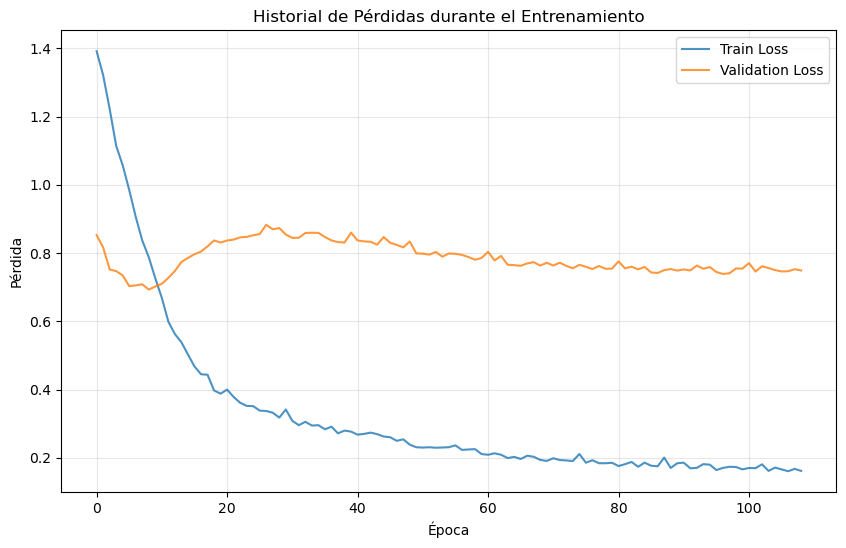

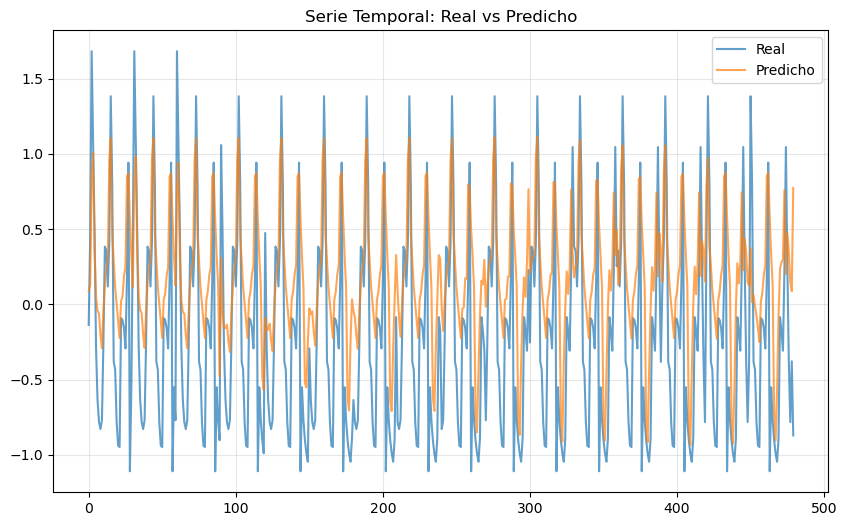

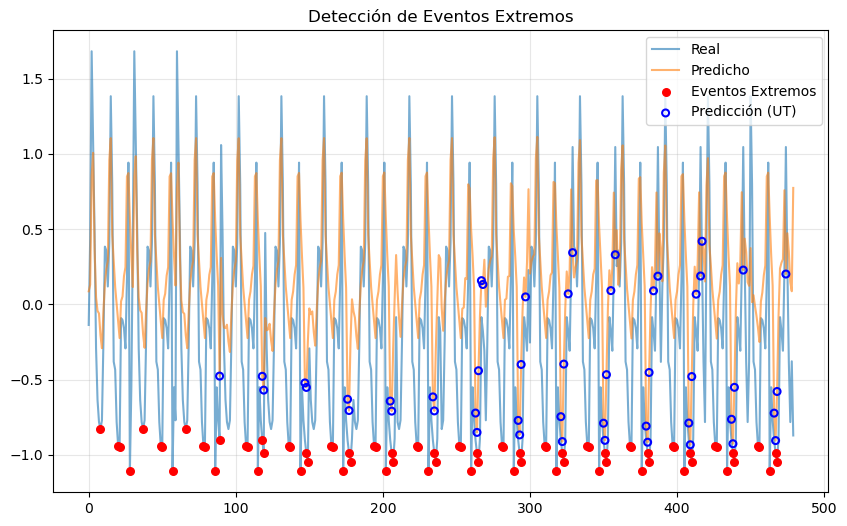

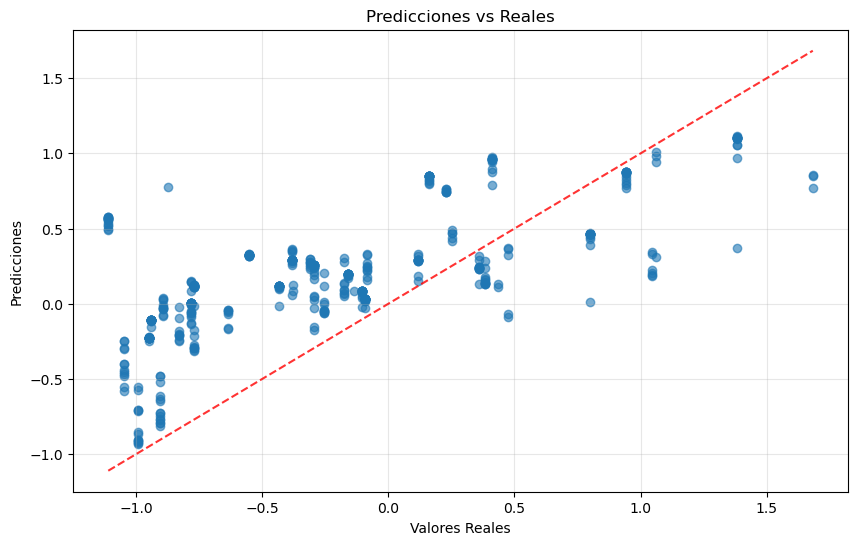

In [ ]:
print("Gráficos individuales")

plt.close('all')

plt.figure(figsize=(10, 6))
plt.plot(loss_history['train'], label='Train Loss', alpha=0.8)
plt.plot(loss_history['val'], label='Validation Loss', alpha=0.8)
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Historial de Pérdidas durante el Entrenamiento')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(num="Serie Temporal: Real vs Predicho", figsize=(10, 6))
plt.plot(targets, label='Real', alpha=0.7)
plt.plot(predictions, label='Predicho', alpha=0.7)
plt.title('Serie Temporal: Real vs Predicho')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(num="Detección de Eventos Extremos", figsize=(10, 6))

pred = np.ravel(predictions)
real = np.ravel(targets)
ut_arr = np.ravel(ut) 
vt_arr = np.ravel(vt)

T = len(pred)
real = real[-T:]
vt_plot = vt_arr[1:1+T] if len(vt_arr) >= T+1 else vt_arr[-T:]
x = np.arange(T)

true_mask = (vt_plot == -1)
plt.plot(x, real, alpha=0.6, label='Real')
plt.plot(x, pred, alpha=0.6, label='Predicho')
plt.scatter(x[true_mask], real[true_mask], c='red', s=30,
            label='Eventos Extremos', zorder=5)

umbral = float(getattr(entrenador.model, "umbral_ut",
                       getattr(entrenador.model, "p_minimo", 0.1)))
if umbral > 1:
    umbral /= 100.0
pred_mask = (ut_arr[-T:] <= -umbral)
plt.scatter(x[pred_mask], pred[pred_mask], s=25, facecolors='none',
            edgecolors='blue', linewidths=1.5, label='Predicción (UT)', zorder=6)

plt.title('Detección de Eventos Extremos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(num="Predicciones vs Reales", figsize=(10, 6))
plt.scatter(targets, predictions, alpha=0.6)
min_val = min(np.min(targets), np.min(predictions))
max_val = max(np.max(targets), np.max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Reales')
plt.grid(True, alpha=0.3)
plt.show()
